# Run the constrained FaIR ensemble driven by concentrations

for comparison in box 7.1

In [1]:
import fair
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
import scipy.stats as st
import os
import errno
import random
import json
import warnings
import datetime as dt
from multiprocessing import Pool
from ar6.utils import mkdir_p
from scipy.interpolate import interp1d
from fair.forward import fair_scm
from fair.inverse import inverse_fair_scm
from fair.constants.general import ppm_gtc
from fair.constants import molwt
from fair.forcing.ghg import co2_log
from fair.RCPs import rcp26, rcp45, rcp60, rcp85
from fair.tools.constrain import hist_temp
from fair.constants.general import EARTH_RADIUS, SECONDS_PER_YEAR
from tqdm.notebook import tqdm

from scmdata.run import ScmRun, run_append
from scmdata.netcdf import nc_to_run

from netCDF4 import Dataset

NTOA_ZJ = 4 * np.pi * EARTH_RADIUS**2 * SECONDS_PER_YEAR * 1e-21

<IPython.core.display.Javascript object>

In [2]:
fair.__version__

'1.6.2'

In [3]:
with open('../data_output_large/fair-samples/fair-1.6.2-wg3-params.json') as f:
    config_list = json.load(f)

In [4]:
config_list[0]
len(config_list)

2049

In [5]:
climate_model = 'FaIRv%s' % fair.__version__
model         = 'unspecified'
region        = 'World'

In [6]:
VARIABLES = [
        "Surface Temperature",
        "Surface Temperature (GMST)",
        "Effective Radiative Forcing",
        "Effective Radiative Forcing|CO2",
        "Effective Radiative Forcing|CH4",
        "Effective Radiative Forcing|N2O",
        "Effective Radiative Forcing|Greenhouse Gases",
        "Effective Radiative Forcing|Aerosols",
        "Effective Radiative Forcing|Aerosols|Direct Effect|BC",
        "Effective Radiative Forcing|Aerosols|Direct Effect|OC",
        "Effective Radiative Forcing|Aerosols|Direct Effect|Sulfur",
        "Effective Radiative Forcing|Aerosols|Direct Effect|Nitrate",
        "Effective Radiative Forcing|Aerosols|Direct Effect",
        "Effective Radiative Forcing|Aerosols|Indirect Effect",
        "Heat Uptake",
        "Heat Uptake|Ocean",
        "Airborne Fraction|CO2",
        "Cumulative Emissions|CO2",
        "Instantaneous TCRE",
    ]

UNITS = [
        'K',
        'K',
        'W/m^2',
        'W/m^2',
        'W/m^2',
        'W/m^2',
        'W/m^2',
        'W/m^2',
        'W/m^2',
        'W/m^2',
        'W/m^2',
        'W/m^2',
        'W/m^2',
        'W/m^2',
        'ZJ/yr',
        'ZJ/yr',
        'Dimensionless',
        'MtCO2',
        'K/MtCO2'
    ]

NVAR = len(VARIABLES)

In [7]:
conc_all = pd.read_csv('../data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv')

## 1pctCO2

In [8]:
conc_subset = conc_all[(conc_all['Model']=='unspecified')&(conc_all['Scenario']=='1pctCO2')&(conc_all['Region']=='World')]
gases=['CO2','CH4','N2O','CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
       'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
       'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','CH3Cl']
conc = np.zeros((151,31))
for ig, gas in enumerate(gases):
    try:
        conc[:,ig] = conc_subset[conc_subset.Variable.str.endswith(gas)].loc[:,'1850':'2000'].values
    except:
        conc[:,ig] = 0

In [9]:
results = np.empty((151,0))
expt = '1pctCO2'

def run_fair(args):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        C,F,T,ariaci, lambda_eff, ohc, heatflux = fair_scm(
            emissions_driven=False,
            C_pi = conc[0,:],
            C = conc,
            F_volcanic=0,
            F_solar=0,
            F2x=args['F2x'],
            ariaci_out=True,
            ghg_forcing='Meinshausen',
            efficacy=np.ones(13),
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
        )

        E,Fe,Te,lambda_effe, ohce, heatfluxe, af = inverse_fair_scm(
            conc[:,0],
            F2x=args['F2x'],
            C_pi = conc[0,0],
            r0=args['r0'],
            rt=args['rt'],
            rc=args['rc'],
            F_in = np.sum(F, axis=1),
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
            )
    
        nt = len(T)
        cumE = np.cumsum(E) * molwt.CO2/molwt.C*1000.
        Catmpool = C[:,0]*ppm_gtc*molwt.CO2/molwt.C*1000.
        Cburden = (C[:,0]-C[0,0])*ppm_gtc*molwt.CO2/molwt.C*1000.
        ECSeff = args['F2x'] * 0.4778646 / lambda_eff
        af = Cburden/cumE
    
        return (T, np.sum(F, axis=1), heatflux*NTOA_ZJ, af, cumE, T/cumE)

if __name__ == '__main__':
    with Pool(16) as pool:
        result = list(tqdm(pool.imap(run_fair, config_list), total=len(config_list)))

  0%|          | 0/2049 [00:00<?, ?it/s]

In [10]:
len(result[0])

6

In [11]:
result_t = np.array(result).transpose(1,2,0)
nt = result_t.shape[1]

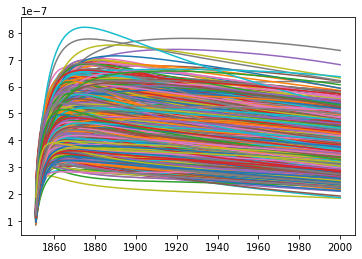

In [12]:
pl.plot(np.arange(1850,1850+nt), result_t[5,:,:]);

array([1.37735522, 1.51365696, 1.78521582, 2.11558707, 2.40025683])

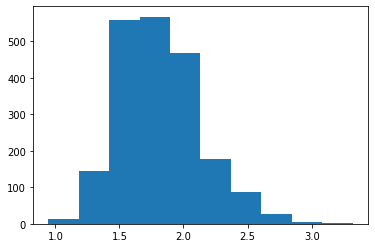

In [13]:
# concentration driven TCR estimate
pl.hist(result_t[0,70,:])
np.percentile(result_t[0,70,:], (5,16,50,84,95))

array([4.13431349, 4.2031742 , 4.31421943, 4.44325235, 4.5340559 ])

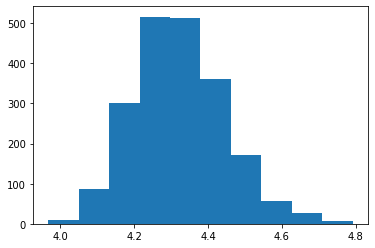

In [14]:
# cumulative emissions
pl.hist(result_t[4,70,:]  / 1000000)
np.percentile(result_t[4,70,:]  / 1000000, (5,16,50,84,95))

array([0.49249701, 0.50256182, 0.51759281, 0.53126729, 0.54011602])

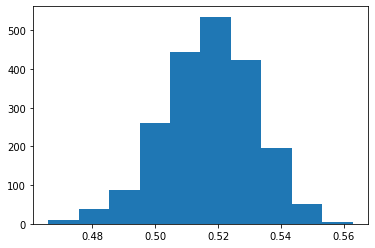

In [15]:
# airborne fraction after 70 years
pl.hist(result_t[3,70,:])
np.percentile(result_t[3,70,:], (5,16,50,84,95))

In [16]:
280 * 2.12

# ppm * GtC / ppm = GtC

593.6

array([1.18825674, 1.30796986, 1.55554248, 1.84522954, 2.10354319])

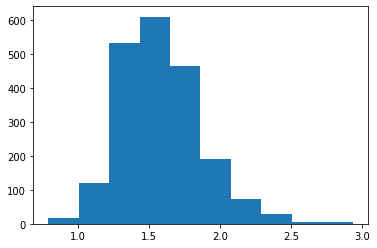

In [17]:
tcre = result_t[3,70,:] * result_t[0,70,:] / 0.593
#      [dimensionless]  * K / (CO2 doubling)

# where does 0.6 come from? IT'S THE CONVERSION FROM PPM TO GtC FOR A CO2 DOUBLING

#results.shape
pl.hist(tcre)
np.percentile(tcre, (5,16,50,84,95))

In [18]:
def new_timeseries(
    data,
    n=100,
    climate_model="FaIRv%s" % fair.__version__,
    model='unspecified',
    scenario="unspecified",
    variable="unspecified",
    unit="unspecified",
    region="World",
    cls=ScmRun,
    **kwargs,
):
    index = 1850 + np.arange(n)
    return cls(
        data,
        columns={
            "model": model,
            "climate_model": climate_model,
            "scenario": scenario,
            "variable": variable,
            "region": region,
            "unit": unit,
            **kwargs,
        },
        index=index,
    )

In [19]:
result_t[:,:,0].shape

(6, 151)

In [20]:
mkdir_p('../data_output_large/fair-samples/concentration_driven/')

In [21]:
VARIABLES_1PCT = [
        "Surface Temperature",
        "Effective Radiative Forcing",
        "Heat Uptake",
        "Airborne Fraction|CO2",
        "Cumulative Emissions|CO2",
        "Instantaneous TCRE",
    ]

UNITS_1PCT = [
        'K',
        'W/m^2',
        'ZJ/yr',
        'Dimensionless',
        'MtCO2',
        'K/TtC'
    ]

NVAR_1PCT = len(VARIABLES_1PCT)

runs = run_append(
    [
        new_timeseries(
            result_t[:,:,ensemble_member].T,
            n=result_t.shape[1],
            scenario=expt,
            variable=VARIABLES_1PCT,
            unit=UNITS_1PCT,
            ensemble_member=ensemble_member,
        )
        for ensemble_member in range(len(config_list))
    ]
)
runs.metadata["source"] = "FaIRv%s AR6 runs %02d.%02d.%d" % (fair.__version__, dt.date.today().day, dt.date.today().month, dt.date.today().year)
runs.to_nc('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_%s.nc' % expt, dimensions=["ensemble_member"])
runs.to_csv('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_%s.csv' % expt)

## ssp119

In [22]:
expt = 'ssp119'
emis_all = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
emis_subset = emis_all[(emis_all['Scenario']==expt)&(emis_all['Region']=='World')]
species=['CO2|MAGICC Fossil and Industrial','CO2|MAGICC AFOLU','CH4','N2O','Sulfur','CO','VOC','NOx','BC','|OC','NH3',
         'CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
         'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
         'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','|CH3Cl']
emis = np.zeros((751,40))
emis[:,0] = np.arange(1750,2501)
for ie, specie in enumerate(species):
    try:
        temp = emis_subset[emis_subset.Variable.str.endswith(specie)].loc[:,'1750':'2500'].values.squeeze()
        emis[:,ie+1] = pd.Series(temp).interpolate().values
    except:
        emis[:,ie+1] = 0
temp = emis_subset[emis_subset['Variable']=='Emissions|NOx|MAGICC Fossil and Industrial|Aircraft'].loc[:,'1750':'2500'].values.squeeze()
aviNOx = pd.Series(temp).interpolate().values
aviNOx_frac = aviNOx/emis[:,8]
# 
unit_convert = np.ones(40)
unit_convert[1]=0.001 * molwt.C/molwt.CO2
unit_convert[2]=0.001 * molwt.C/molwt.CO2
unit_convert[4]=0.001 * molwt.N2/molwt.N2O
unit_convert[5]=molwt.S/molwt.SO2
unit_convert[8]=molwt.N/molwt.NO2

emis = emis * unit_convert

conc_subset = conc_all[(conc_all['Scenario']==expt)&(conc_all['Region']=='World')]
gases=['CO2','CH4','N2O','CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
       'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
       'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','CH3Cl']
conc = np.zeros((751,31))
for ig, gas in enumerate(gases):
    try:
        temp = conc_subset[conc_subset.Variable.str.endswith(gas)].loc[:,'1750':'2500'].values.squeeze()
        conc[:,ig] = pd.Series(temp).interpolate().values
    except:
        conc[:,ig] = 0

nt = 751
def run_fair(args):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        F_solar = np.zeros(751)
        F_volcanic = np.zeros(751)
        F_solar[:351] = args['F_solar']
        F_volcanic[:351] = args['F_volcanic']
        
        C,F,T,ariaci, lambda_eff, ohc, heatflux = fair_scm(
            emissions=emis,
            emissions_driven=False,
            C_pi = conc[0,:],
            C = conc,
            natural=np.zeros((751,2)),
            F_volcanic=F_volcanic,#np.mean(F_volcanic),
            F_solar=F_solar,
            F2x=args['F2x'],
            ariaci_out=True,
            ghg_forcing='Meinshausen',
            scale=np.asarray(args['scale']),
            aerosol_forcing='aerocom+ghan2',
            b_aero = np.asarray(args['b_aero']),
            ghan_params=np.asarray(args['ghan_params']),
            tropO3_forcing='thorhnill+skeie',
            ozone_feedback=args['ozone_feedback'],
            b_tro3 = np.array(args['b_tro3']),
            E_pi=emis[0,:],
            scaleAerosolAR5=False,
            scaleHistoricalAR5=False,
            fixPre1850RCP=False,
            aviNOx_frac=0,
            aCO2land = args['aCO2land'],
            stwv_from_ch4 = args['stwv_from_ch4'],
            F_ref_BC = args['F_ref_BC'],
            E_ref_BC = args['E_ref_BC'],
            efficacy=np.ones(45),
            diagnostics='AR6',
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
        )

        E,Fe,Te,lambda_effe, ohce, heatfluxe, af = inverse_fair_scm(
            conc[:,0],
            F2x=args['F2x'],
            C_pi = conc[0,0],
            r0=args['r0'],
            rt=args['rt'],
            rc=args['rc'],
            F_in = np.sum(F, axis=1),
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
            )

        nt = len(T)
        cumE = np.cumsum(E) * molwt.CO2/molwt.C*1000.
        Catmpool = C[:,0]*ppm_gtc*molwt.CO2/molwt.C*1000.
        Cburden = (C[:,0]-C[0,0])*ppm_gtc*molwt.CO2/molwt.C*1000.
        ECSeff = args['F2x'] * 0.4778646 / lambda_eff
        af = Cburden/cumE

        return(
            T, T/1.04, np.sum(F, axis=1), F[:,0], F[:,1], F[:,2], np.sum(F[:,:31], axis=1),
            np.sum(F[:,35:41], axis=1), F[:,38], F[:,39], F[:,35], F[:,37],
            ariaci[:,0], ariaci[:,1], heatflux*NTOA_ZJ, heatflux*NTOA_ZJ*0.92,
            af, cumE, T/cumE
        )
    
if __name__ == '__main__':
    with Pool(16) as pool:
        result = list(tqdm(pool.imap(run_fair, config_list), total=len(config_list)))
    result_t = np.array(result).transpose(1,2,0)

  0%|          | 0/2049 [00:00<?, ?it/s]

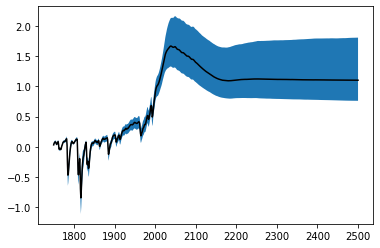

In [23]:
pl.fill_between(np.arange(1750, 1750+nt), np.percentile(result_t[0,...], 5, axis=1), np.percentile(result_t[0,...], 95, axis=1))
pl.plot(np.arange(1750,1750+nt), np.percentile(result_t[0,...], 50, axis=1), color='k');

In [24]:
def new_timeseries(
    data,
    n=100,
    climate_model="FaIRv%s" % fair.__version__,
    model='unspecified',
    scenario="unspecified",
    variable="unspecified",
    unit="unspecified",
    region="World",
    cls=ScmRun,
    **kwargs,
):

    index = 1750 + np.arange(n)
    return cls(
        data,
        columns={
            "model": model,
            "climate_model": climate_model,
            "scenario": scenario,
            "variable": variable,
            "region": region,
            "unit": unit,
            **kwargs,
        },
        index=index,
    )

In [25]:
runs = run_append(
    [
        new_timeseries(
            result_t[:,:,ensemble_member].T,
            n=result_t.shape[1],
            scenario=expt,
            variable=VARIABLES,
            unit=UNITS,
            ensemble_member=ensemble_member,
        )
        for ensemble_member in range(len(config_list))
    ]
)
runs.metadata["source"] = "FaIRv%s AR6 runs %02d.%02d.%d" % (fair.__version__, dt.date.today().day, dt.date.today().month, dt.date.today().year)
runs.to_nc('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_%s.nc' % expt, dimensions=["ensemble_member"])
runs.to_csv('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_%s.csv' % expt)

## ssp126

In [26]:
expt = 'ssp126'
emis_all = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
emis_subset = emis_all[(emis_all['Scenario']==expt)&(emis_all['Region']=='World')]
species=['CO2|MAGICC Fossil and Industrial','CO2|MAGICC AFOLU','CH4','N2O','Sulfur','CO','VOC','NOx','BC','|OC','NH3',
         'CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
         'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
         'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','|CH3Cl']
emis = np.zeros((751,40))
emis[:,0] = np.arange(1750,2501)
for ie, specie in enumerate(species):
    try:
        temp = emis_subset[emis_subset.Variable.str.endswith(specie)].loc[:,'1750':'2500'].values.squeeze()
        emis[:,ie+1] = pd.Series(temp).interpolate().values
    except:
        emis[:,ie+1] = 0
temp = emis_subset[emis_subset['Variable']=='Emissions|NOx|MAGICC Fossil and Industrial|Aircraft'].loc[:,'1750':'2500'].values.squeeze()
aviNOx = pd.Series(temp).interpolate().values
aviNOx_frac = aviNOx/emis[:,8]
# 
unit_convert = np.ones(40)
unit_convert[1]=0.001 * molwt.C/molwt.CO2
unit_convert[2]=0.001 * molwt.C/molwt.CO2
unit_convert[4]=0.001 * molwt.N2/molwt.N2O
unit_convert[5]=molwt.S/molwt.SO2
unit_convert[8]=molwt.N/molwt.NO2

emis = emis * unit_convert

conc_subset = conc_all[(conc_all['Scenario']==expt)&(conc_all['Region']=='World')]
gases=['CO2','CH4','N2O','CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
       'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
       'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','CH3Cl']
conc = np.zeros((751,31))
for ig, gas in enumerate(gases):
    try:
        temp = conc_subset[conc_subset.Variable.str.endswith(gas)].loc[:,'1750':'2500'].values.squeeze()
        conc[:,ig] = pd.Series(temp).interpolate().values
    except:
        conc[:,ig] = 0

nt = 751
def run_fair(args):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        F_solar = np.zeros(751)
        F_volcanic = np.zeros(751)
        F_solar[:351] = args['F_solar']
        F_volcanic[:351] = args['F_volcanic']
        
        C,F,T,ariaci, lambda_eff, ohc, heatflux = fair_scm(
            emissions=emis,
            emissions_driven=False,
            C_pi = conc[0,:],
            C = conc,
            natural=np.zeros((751,2)),
            F_volcanic=F_volcanic,#np.mean(F_volcanic),
            F_solar=F_solar,
            F2x=args['F2x'],
            ariaci_out=True,
            ghg_forcing='Meinshausen',
            scale=np.asarray(args['scale']),
            aerosol_forcing='aerocom+ghan2',
            b_aero = np.asarray(args['b_aero']),
            ghan_params=np.asarray(args['ghan_params']),
            tropO3_forcing='thorhnill+skeie',
            ozone_feedback=args['ozone_feedback'],
            b_tro3 = np.array(args['b_tro3']),
            E_pi=emis[0,:],
            scaleAerosolAR5=False,
            scaleHistoricalAR5=False,
            fixPre1850RCP=False,
            aviNOx_frac=0,
            aCO2land = args['aCO2land'],
            stwv_from_ch4 = args['stwv_from_ch4'],
            F_ref_BC = args['F_ref_BC'],
            E_ref_BC = args['E_ref_BC'],
            efficacy=np.ones(45),
            diagnostics='AR6',
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
        )

        E,Fe,Te,lambda_effe, ohce, heatfluxe, af = inverse_fair_scm(
            conc[:,0],
            F2x=args['F2x'],
            C_pi = conc[0,0],
            r0=args['r0'],
            rt=args['rt'],
            rc=args['rc'],
            F_in = np.sum(F, axis=1),
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
            )

        nt = len(T)
        cumE = np.cumsum(E) * molwt.CO2/molwt.C*1000.
        Catmpool = C[:,0]*ppm_gtc*molwt.CO2/molwt.C*1000.
        Cburden = (C[:,0]-C[0,0])*ppm_gtc*molwt.CO2/molwt.C*1000.
        ECSeff = args['F2x'] * 0.4778646 / lambda_eff
        af = Cburden/cumE

        return(
            T, T/1.04, np.sum(F, axis=1), F[:,0], F[:,1], F[:,2], np.sum(F[:,:31], axis=1),
            np.sum(F[:,35:41], axis=1), F[:,38], F[:,39], F[:,35], F[:,37],
            ariaci[:,0], ariaci[:,1], heatflux*NTOA_ZJ, heatflux*NTOA_ZJ*0.92,
            af, cumE, T/cumE
        )
    
if __name__ == '__main__':
    with Pool(16) as pool:
        result = list(tqdm(pool.imap(run_fair, config_list), total=len(config_list)))
    result_t = np.array(result).transpose(1,2,0)

  0%|          | 0/2049 [00:00<?, ?it/s]

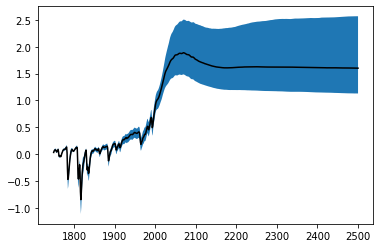

In [27]:
pl.fill_between(np.arange(1750, 1750+nt), np.percentile(result_t[0,...], 5, axis=1), np.percentile(result_t[0,...], 95, axis=1))
pl.plot(np.arange(1750,1750+nt), np.percentile(result_t[0,...], 50, axis=1), color='k');

In [28]:
runs = run_append(
    [
        new_timeseries(
            result_t[:,:,ensemble_member].T,
            n=result_t.shape[1],
            scenario=expt,
            variable=VARIABLES,
            unit=UNITS,
            ensemble_member=ensemble_member,
        )
        for ensemble_member in range(len(config_list))
    ]
)
runs.metadata["source"] = "FaIRv%s AR6 runs %02d.%02d.%d" % (fair.__version__, dt.date.today().day, dt.date.today().month, dt.date.today().year)
runs.to_nc('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_%s.nc' % expt, dimensions=["ensemble_member"])
runs.to_csv('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_%s.csv' % expt)

## ssp245

In [29]:
expt = 'ssp245'
emis_all = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
emis_subset = emis_all[(emis_all['Scenario']==expt)&(emis_all['Region']=='World')]
species=['CO2|MAGICC Fossil and Industrial','CO2|MAGICC AFOLU','CH4','N2O','Sulfur','CO','VOC','NOx','BC','|OC','NH3',
         'CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
         'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
         'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','|CH3Cl']
emis = np.zeros((751,40))
emis[:,0] = np.arange(1750,2501)
for ie, specie in enumerate(species):
    try:
        temp = emis_subset[emis_subset.Variable.str.endswith(specie)].loc[:,'1750':'2500'].values.squeeze()
        emis[:,ie+1] = pd.Series(temp).interpolate().values
    except:
        emis[:,ie+1] = 0
temp = emis_subset[emis_subset['Variable']=='Emissions|NOx|MAGICC Fossil and Industrial|Aircraft'].loc[:,'1750':'2500'].values.squeeze()
aviNOx = pd.Series(temp).interpolate().values
aviNOx_frac = aviNOx/emis[:,8]
# 
unit_convert = np.ones(40)
unit_convert[1]=0.001 * molwt.C/molwt.CO2
unit_convert[2]=0.001 * molwt.C/molwt.CO2
unit_convert[4]=0.001 * molwt.N2/molwt.N2O
unit_convert[5]=molwt.S/molwt.SO2
unit_convert[8]=molwt.N/molwt.NO2

emis = emis * unit_convert

conc_subset = conc_all[(conc_all['Scenario']==expt)&(conc_all['Region']=='World')]
gases=['CO2','CH4','N2O','CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
       'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
       'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','CH3Cl']
conc = np.zeros((751,31))
for ig, gas in enumerate(gases):
    try:
        temp = conc_subset[conc_subset.Variable.str.endswith(gas)].loc[:,'1750':'2500'].values.squeeze()
        conc[:,ig] = pd.Series(temp).interpolate().values
    except:
        conc[:,ig] = 0

nt = 751
def run_fair(args):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        F_solar = np.zeros(751)
        F_volcanic = np.zeros(751)
        F_solar[:351] = args['F_solar']
        F_volcanic[:351] = args['F_volcanic']
        
        C,F,T,ariaci, lambda_eff, ohc, heatflux = fair_scm(
            emissions=emis,
            emissions_driven=False,
            C_pi = conc[0,:],
            C = conc,
            natural=np.zeros((751,2)),
            F_volcanic=F_volcanic,#np.mean(F_volcanic),
            F_solar=F_solar,
            F2x=args['F2x'],
            ariaci_out=True,
            ghg_forcing='Meinshausen',
            scale=np.asarray(args['scale']),
            aerosol_forcing='aerocom+ghan2',
            b_aero = np.asarray(args['b_aero']),
            ghan_params=np.asarray(args['ghan_params']),
            tropO3_forcing='thorhnill+skeie',
            ozone_feedback=args['ozone_feedback'],
            b_tro3 = np.array(args['b_tro3']),
            E_pi=emis[0,:],
            scaleAerosolAR5=False,
            scaleHistoricalAR5=False,
            fixPre1850RCP=False,
            aviNOx_frac=0,
            aCO2land = args['aCO2land'],
            stwv_from_ch4 = args['stwv_from_ch4'],
            F_ref_BC = args['F_ref_BC'],
            E_ref_BC = args['E_ref_BC'],
            efficacy=np.ones(45),
            diagnostics='AR6',
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
        )

        E,Fe,Te,lambda_effe, ohce, heatfluxe, af = inverse_fair_scm(
            conc[:,0],
            F2x=args['F2x'],
            C_pi = conc[0,0],
            r0=args['r0'],
            rt=args['rt'],
            rc=args['rc'],
            F_in = np.sum(F, axis=1),
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
            )

        nt = len(T)
        cumE = np.cumsum(E) * molwt.CO2/molwt.C*1000.
        Catmpool = C[:,0]*ppm_gtc*molwt.CO2/molwt.C*1000.
        Cburden = (C[:,0]-C[0,0])*ppm_gtc*molwt.CO2/molwt.C*1000.
        ECSeff = args['F2x'] * 0.4778646 / lambda_eff
        af = Cburden/cumE

        return(
            T, T/1.04, np.sum(F, axis=1), F[:,0], F[:,1], F[:,2], np.sum(F[:,:31], axis=1),
            np.sum(F[:,35:41], axis=1), F[:,38], F[:,39], F[:,35], F[:,37],
            ariaci[:,0], ariaci[:,1], heatflux*NTOA_ZJ, heatflux*NTOA_ZJ*0.92,
            af, cumE, T/cumE
        )
    
if __name__ == '__main__':
    with Pool(16) as pool:
        result = list(tqdm(pool.imap(run_fair, config_list), total=len(config_list)))
    result_t = np.array(result).transpose(1,2,0)

  0%|          | 0/2049 [00:00<?, ?it/s]

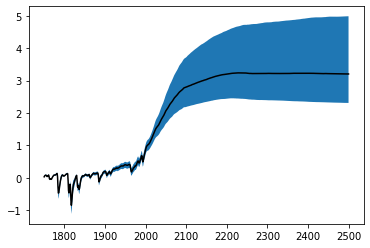

In [30]:
pl.fill_between(np.arange(1750, 1750+nt), np.percentile(result_t[0,...], 5, axis=1), np.percentile(result_t[0,...], 95, axis=1))
pl.plot(np.arange(1750,1750+nt), np.percentile(result_t[0,...], 50, axis=1), color='k');

In [31]:
runs = run_append(
    [
        new_timeseries(
            result_t[:,:,ensemble_member].T,
            n=result_t.shape[1],
            scenario=expt,
            variable=VARIABLES,
            unit=UNITS,
            ensemble_member=ensemble_member,
        )
        for ensemble_member in range(len(config_list))
    ]
)
runs.metadata["source"] = "FaIRv%s AR6 runs %02d.%02d.%d" % (fair.__version__, dt.date.today().day, dt.date.today().month, dt.date.today().year)
runs.to_nc('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_%s.nc' % expt, dimensions=["ensemble_member"])
runs.to_csv('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_%s.csv' % expt)

## ssp370

In [32]:
expt = 'ssp370'
emis_all = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
emis_subset = emis_all[(emis_all['Scenario']==expt)&(emis_all['Region']=='World')]
species=['CO2|MAGICC Fossil and Industrial','CO2|MAGICC AFOLU','CH4','N2O','Sulfur','CO','VOC','NOx','BC','|OC','NH3',
         'CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
         'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
         'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','|CH3Cl']
emis = np.zeros((751,40))
emis[:,0] = np.arange(1750,2501)
for ie, specie in enumerate(species):
    try:
        temp = emis_subset[emis_subset.Variable.str.endswith(specie)].loc[:,'1750':'2500'].values.squeeze()
        emis[:,ie+1] = pd.Series(temp).interpolate().values
    except:
        emis[:,ie+1] = 0
temp = emis_subset[emis_subset['Variable']=='Emissions|NOx|MAGICC Fossil and Industrial|Aircraft'].loc[:,'1750':'2500'].values.squeeze()
aviNOx = pd.Series(temp).interpolate().values
aviNOx_frac = aviNOx/emis[:,8]
# 
unit_convert = np.ones(40)
unit_convert[1]=0.001 * molwt.C/molwt.CO2
unit_convert[2]=0.001 * molwt.C/molwt.CO2
unit_convert[4]=0.001 * molwt.N2/molwt.N2O
unit_convert[5]=molwt.S/molwt.SO2
unit_convert[8]=molwt.N/molwt.NO2

emis = emis * unit_convert

conc_subset = conc_all[(conc_all['Scenario']==expt)&(conc_all['Region']=='World')]
gases=['CO2','CH4','N2O','CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
       'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
       'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','CH3Cl']
conc = np.zeros((751,31))
for ig, gas in enumerate(gases):
    try:
        temp = conc_subset[conc_subset.Variable.str.endswith(gas)].loc[:,'1750':'2500'].values.squeeze()
        conc[:,ig] = pd.Series(temp).interpolate().values
    except:
        conc[:,ig] = 0

nt = 751
def run_fair(args):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        F_solar = np.zeros(751)
        F_volcanic = np.zeros(751)
        F_solar[:351] = args['F_solar']
        F_volcanic[:351] = args['F_volcanic']
        
        C,F,T,ariaci, lambda_eff, ohc, heatflux = fair_scm(
            emissions=emis,
            emissions_driven=False,
            C_pi = conc[0,:],
            C = conc,
            natural=np.zeros((751,2)),
            F_volcanic=F_volcanic,#np.mean(F_volcanic),
            F_solar=F_solar,
            F2x=args['F2x'],
            ariaci_out=True,
            ghg_forcing='Meinshausen',
            scale=np.asarray(args['scale']),
            aerosol_forcing='aerocom+ghan2',
            b_aero = np.asarray(args['b_aero']),
            ghan_params=np.asarray(args['ghan_params']),
            tropO3_forcing='thorhnill+skeie',
            ozone_feedback=args['ozone_feedback'],
            b_tro3 = np.array(args['b_tro3']),
            E_pi=emis[0,:],
            scaleAerosolAR5=False,
            scaleHistoricalAR5=False,
            fixPre1850RCP=False,
            aviNOx_frac=0,
            aCO2land = args['aCO2land'],
            stwv_from_ch4 = args['stwv_from_ch4'],
            F_ref_BC = args['F_ref_BC'],
            E_ref_BC = args['E_ref_BC'],
            efficacy=np.ones(45),
            diagnostics='AR6',
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
        )

        E,Fe,Te,lambda_effe, ohce, heatfluxe, af = inverse_fair_scm(
            conc[:,0],
            F2x=args['F2x'],
            C_pi = conc[0,0],
            r0=args['r0'],
            rt=args['rt'],
            rc=args['rc'],
            F_in = np.sum(F, axis=1),
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
            )

        nt = len(T)
        cumE = np.cumsum(E) * molwt.CO2/molwt.C*1000.
        Catmpool = C[:,0]*ppm_gtc*molwt.CO2/molwt.C*1000.
        Cburden = (C[:,0]-C[0,0])*ppm_gtc*molwt.CO2/molwt.C*1000.
        ECSeff = args['F2x'] * 0.4778646 / lambda_eff
        af = Cburden/cumE

        return(
            T, T/1.04, np.sum(F, axis=1), F[:,0], F[:,1], F[:,2], np.sum(F[:,:31], axis=1),
            np.sum(F[:,35:41], axis=1), F[:,38], F[:,39], F[:,35], F[:,37],
            ariaci[:,0], ariaci[:,1], heatflux*NTOA_ZJ, heatflux*NTOA_ZJ*0.92,
            af, cumE, T/cumE
        )
    
if __name__ == '__main__':
    with Pool(16) as pool:
        result = list(tqdm(pool.imap(run_fair, config_list), total=len(config_list)))
    result_t = np.array(result).transpose(1,2,0)

  0%|          | 0/2049 [00:00<?, ?it/s]

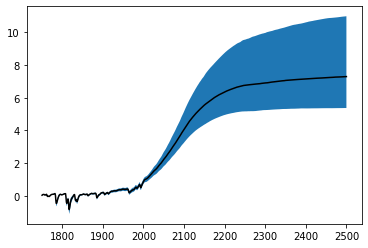

In [33]:
pl.fill_between(np.arange(1750, 1750+nt), np.percentile(result_t[0,...], 5, axis=1), np.percentile(result_t[0,...], 95, axis=1))
pl.plot(np.arange(1750,1750+nt), np.percentile(result_t[0,...], 50, axis=1), color='k');

In [34]:
runs = run_append(
    [
        new_timeseries(
            result_t[:,:,ensemble_member].T,
            n=result_t.shape[1],
            scenario=expt,
            variable=VARIABLES,
            unit=UNITS,
            ensemble_member=ensemble_member,
        )
        for ensemble_member in range(len(config_list))
    ]
)
runs.metadata["source"] = "FaIRv%s AR6 runs %02d.%02d.%d" % (fair.__version__, dt.date.today().day, dt.date.today().month, dt.date.today().year)
runs.to_nc('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_%s.nc' % expt, dimensions=["ensemble_member"])
runs.to_csv('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_%s.csv' % expt)

## ssp434

In [35]:
expt = 'ssp434'
emis_all = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
emis_subset = emis_all[(emis_all['Scenario']==expt)&(emis_all['Region']=='World')]
species=['CO2|MAGICC Fossil and Industrial','CO2|MAGICC AFOLU','CH4','N2O','Sulfur','CO','VOC','NOx','BC','|OC','NH3',
         'CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
         'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
         'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','|CH3Cl']
emis = np.zeros((751,40))
emis[:,0] = np.arange(1750,2501)
for ie, specie in enumerate(species):
    try:
        temp = emis_subset[emis_subset.Variable.str.endswith(specie)].loc[:,'1750':'2500'].values.squeeze()
        emis[:,ie+1] = pd.Series(temp).interpolate().values
    except:
        emis[:,ie+1] = 0
temp = emis_subset[emis_subset['Variable']=='Emissions|NOx|MAGICC Fossil and Industrial|Aircraft'].loc[:,'1750':'2500'].values.squeeze()
aviNOx = pd.Series(temp).interpolate().values
aviNOx_frac = aviNOx/emis[:,8]
# 
unit_convert = np.ones(40)
unit_convert[1]=0.001 * molwt.C/molwt.CO2
unit_convert[2]=0.001 * molwt.C/molwt.CO2
unit_convert[4]=0.001 * molwt.N2/molwt.N2O
unit_convert[5]=molwt.S/molwt.SO2
unit_convert[8]=molwt.N/molwt.NO2

emis = emis * unit_convert

conc_subset = conc_all[(conc_all['Scenario']==expt)&(conc_all['Region']=='World')]
gases=['CO2','CH4','N2O','CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
       'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
       'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','CH3Cl']
conc = np.zeros((751,31))
for ig, gas in enumerate(gases):
    try:
        temp = conc_subset[conc_subset.Variable.str.endswith(gas)].loc[:,'1750':'2500'].values.squeeze()
        conc[:,ig] = pd.Series(temp).interpolate().values
    except:
        conc[:,ig] = 0

nt = 751
def run_fair(args):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        F_solar = np.zeros(751)
        F_volcanic = np.zeros(751)
        F_solar[:351] = args['F_solar']
        F_volcanic[:351] = args['F_volcanic']
        
        C,F,T,ariaci, lambda_eff, ohc, heatflux = fair_scm(
            emissions=emis,
            emissions_driven=False,
            C_pi = conc[0,:],
            C = conc,
            natural=np.zeros((751,2)),
            F_volcanic=F_volcanic,#np.mean(F_volcanic),
            F_solar=F_solar,
            F2x=args['F2x'],
            ariaci_out=True,
            ghg_forcing='Meinshausen',
            scale=np.asarray(args['scale']),
            aerosol_forcing='aerocom+ghan2',
            b_aero = np.asarray(args['b_aero']),
            ghan_params=np.asarray(args['ghan_params']),
            tropO3_forcing='thorhnill+skeie',
            ozone_feedback=args['ozone_feedback'],
            b_tro3 = np.array(args['b_tro3']),
            E_pi=emis[0,:],
            scaleAerosolAR5=False,
            scaleHistoricalAR5=False,
            fixPre1850RCP=False,
            aviNOx_frac=0,
            aCO2land = args['aCO2land'],
            stwv_from_ch4 = args['stwv_from_ch4'],
            F_ref_BC = args['F_ref_BC'],
            E_ref_BC = args['E_ref_BC'],
            efficacy=np.ones(45),
            diagnostics='AR6',
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
        )

        E,Fe,Te,lambda_effe, ohce, heatfluxe, af = inverse_fair_scm(
            conc[:,0],
            F2x=args['F2x'],
            C_pi = conc[0,0],
            r0=args['r0'],
            rt=args['rt'],
            rc=args['rc'],
            F_in = np.sum(F, axis=1),
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
            )

        nt = len(T)
        cumE = np.cumsum(E) * molwt.CO2/molwt.C*1000.
        Catmpool = C[:,0]*ppm_gtc*molwt.CO2/molwt.C*1000.
        Cburden = (C[:,0]-C[0,0])*ppm_gtc*molwt.CO2/molwt.C*1000.
        ECSeff = args['F2x'] * 0.4778646 / lambda_eff
        af = Cburden/cumE

        return(
            T, T/1.04, np.sum(F, axis=1), F[:,0], F[:,1], F[:,2], np.sum(F[:,:31], axis=1),
            np.sum(F[:,35:41], axis=1), F[:,38], F[:,39], F[:,35], F[:,37],
            ariaci[:,0], ariaci[:,1], heatflux*NTOA_ZJ, heatflux*NTOA_ZJ*0.92,
            af, cumE, T/cumE
        )
    
if __name__ == '__main__':
    with Pool(16) as pool:
        result = list(tqdm(pool.imap(run_fair, config_list), total=len(config_list)))
    result_t = np.array(result).transpose(1,2,0)

  0%|          | 0/2049 [00:00<?, ?it/s]

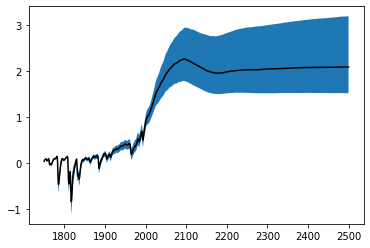

In [36]:
pl.fill_between(np.arange(1750, 1750+nt), np.percentile(result_t[0,...], 5, axis=1), np.percentile(result_t[0,...], 95, axis=1))
pl.plot(np.arange(1750,1750+nt), np.percentile(result_t[0,...], 50, axis=1), color='k');

In [37]:
runs = run_append(
    [
        new_timeseries(
            result_t[:,:,ensemble_member].T,
            n=result_t.shape[1],
            scenario=expt,
            variable=VARIABLES,
            unit=UNITS,
            ensemble_member=ensemble_member,
        )
        for ensemble_member in range(len(config_list))
    ]
)
runs.metadata["source"] = "FaIRv%s AR6 runs %02d.%02d.%d" % (fair.__version__, dt.date.today().day, dt.date.today().month, dt.date.today().year)
runs.to_nc('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_%s.nc' % expt, dimensions=["ensemble_member"])
runs.to_csv('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_%s.csv' % expt)

## ssp460

In [38]:
expt = 'ssp460'
emis_all = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
emis_subset = emis_all[(emis_all['Scenario']==expt)&(emis_all['Region']=='World')]
species=['CO2|MAGICC Fossil and Industrial','CO2|MAGICC AFOLU','CH4','N2O','Sulfur','CO','VOC','NOx','BC','|OC','NH3',
         'CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
         'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
         'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','|CH3Cl']
emis = np.zeros((751,40))
emis[:,0] = np.arange(1750,2501)
for ie, specie in enumerate(species):
    try:
        temp = emis_subset[emis_subset.Variable.str.endswith(specie)].loc[:,'1750':'2500'].values.squeeze()
        emis[:,ie+1] = pd.Series(temp).interpolate().values
    except:
        emis[:,ie+1] = 0
temp = emis_subset[emis_subset['Variable']=='Emissions|NOx|MAGICC Fossil and Industrial|Aircraft'].loc[:,'1750':'2500'].values.squeeze()
aviNOx = pd.Series(temp).interpolate().values
aviNOx_frac = aviNOx/emis[:,8]
# 
unit_convert = np.ones(40)
unit_convert[1]=0.001 * molwt.C/molwt.CO2
unit_convert[2]=0.001 * molwt.C/molwt.CO2
unit_convert[4]=0.001 * molwt.N2/molwt.N2O
unit_convert[5]=molwt.S/molwt.SO2
unit_convert[8]=molwt.N/molwt.NO2

emis = emis * unit_convert

conc_subset = conc_all[(conc_all['Scenario']==expt)&(conc_all['Region']=='World')]
gases=['CO2','CH4','N2O','CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
       'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
       'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','CH3Cl']
conc = np.zeros((751,31))
for ig, gas in enumerate(gases):
    try:
        temp = conc_subset[conc_subset.Variable.str.endswith(gas)].loc[:,'1750':'2500'].values.squeeze()
        conc[:,ig] = pd.Series(temp).interpolate().values
    except:
        conc[:,ig] = 0

nt = 751
def run_fair(args):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        F_solar = np.zeros(751)
        F_volcanic = np.zeros(751)
        F_solar[:351] = args['F_solar']
        F_volcanic[:351] = args['F_volcanic']
        
        C,F,T,ariaci, lambda_eff, ohc, heatflux = fair_scm(
            emissions=emis,
            emissions_driven=False,
            C_pi = conc[0,:],
            C = conc,
            natural=np.zeros((751,2)),
            F_volcanic=F_volcanic,#np.mean(F_volcanic),
            F_solar=F_solar,
            F2x=args['F2x'],
            ariaci_out=True,
            ghg_forcing='Meinshausen',
            scale=np.asarray(args['scale']),
            aerosol_forcing='aerocom+ghan2',
            b_aero = np.asarray(args['b_aero']),
            ghan_params=np.asarray(args['ghan_params']),
            tropO3_forcing='thorhnill+skeie',
            ozone_feedback=args['ozone_feedback'],
            b_tro3 = np.array(args['b_tro3']),
            E_pi=emis[0,:],
            scaleAerosolAR5=False,
            scaleHistoricalAR5=False,
            fixPre1850RCP=False,
            aviNOx_frac=0,
            aCO2land = args['aCO2land'],
            stwv_from_ch4 = args['stwv_from_ch4'],
            F_ref_BC = args['F_ref_BC'],
            E_ref_BC = args['E_ref_BC'],
            efficacy=np.ones(45),
            diagnostics='AR6',
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
        )

        E,Fe,Te,lambda_effe, ohce, heatfluxe, af = inverse_fair_scm(
            conc[:,0],
            F2x=args['F2x'],
            C_pi = conc[0,0],
            r0=args['r0'],
            rt=args['rt'],
            rc=args['rc'],
            F_in = np.sum(F, axis=1),
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
            )

        nt = len(T)
        cumE = np.cumsum(E) * molwt.CO2/molwt.C*1000.
        Catmpool = C[:,0]*ppm_gtc*molwt.CO2/molwt.C*1000.
        Cburden = (C[:,0]-C[0,0])*ppm_gtc*molwt.CO2/molwt.C*1000.
        ECSeff = args['F2x'] * 0.4778646 / lambda_eff
        af = Cburden/cumE

        return(
            T, T/1.04, np.sum(F, axis=1), F[:,0], F[:,1], F[:,2], np.sum(F[:,:31], axis=1),
            np.sum(F[:,35:41], axis=1), F[:,38], F[:,39], F[:,35], F[:,37],
            ariaci[:,0], ariaci[:,1], heatflux*NTOA_ZJ, heatflux*NTOA_ZJ*0.92,
            af, cumE, T/cumE
        )
    
if __name__ == '__main__':
    with Pool(16) as pool:
        result = list(tqdm(pool.imap(run_fair, config_list), total=len(config_list)))
    result_t = np.array(result).transpose(1,2,0)

  0%|          | 0/2049 [00:00<?, ?it/s]

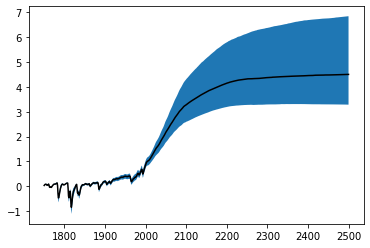

In [39]:
pl.fill_between(np.arange(1750, 1750+nt), np.percentile(result_t[0,...], 5, axis=1), np.percentile(result_t[0,...], 95, axis=1))
pl.plot(np.arange(1750,1750+nt), np.percentile(result_t[0,...], 50, axis=1), color='k');

In [40]:
runs = run_append(
    [
        new_timeseries(
            result_t[:,:,ensemble_member].T,
            n=result_t.shape[1],
            scenario=expt,
            variable=VARIABLES,
            unit=UNITS,
            ensemble_member=ensemble_member,
        )
        for ensemble_member in range(len(config_list))
    ]
)
runs.metadata["source"] = "FaIRv%s AR6 runs %02d.%02d.%d" % (fair.__version__, dt.date.today().day, dt.date.today().month, dt.date.today().year)
runs.to_nc('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_%s.nc' % expt, dimensions=["ensemble_member"])
runs.to_csv('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_%s.csv' % expt)

## ssp534-over

In [41]:
expt = 'ssp534-over'
emis_all = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
emis_subset = emis_all[(emis_all['Scenario']==expt)&(emis_all['Region']=='World')]
species=['CO2|MAGICC Fossil and Industrial','CO2|MAGICC AFOLU','CH4','N2O','Sulfur','CO','VOC','NOx','BC','|OC','NH3',
         'CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
         'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
         'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','|CH3Cl']
emis = np.zeros((751,40))
emis[:,0] = np.arange(1750,2501)
for ie, specie in enumerate(species):
    try:
        temp = emis_subset[emis_subset.Variable.str.endswith(specie)].loc[:,'1750':'2500'].values.squeeze()
        emis[:,ie+1] = pd.Series(temp).interpolate().values
    except:
        emis[:,ie+1] = 0
temp = emis_subset[emis_subset['Variable']=='Emissions|NOx|MAGICC Fossil and Industrial|Aircraft'].loc[:,'1750':'2500'].values.squeeze()
aviNOx = pd.Series(temp).interpolate().values
aviNOx_frac = aviNOx/emis[:,8]
# 
unit_convert = np.ones(40)
unit_convert[1]=0.001 * molwt.C/molwt.CO2
unit_convert[2]=0.001 * molwt.C/molwt.CO2
unit_convert[4]=0.001 * molwt.N2/molwt.N2O
unit_convert[5]=molwt.S/molwt.SO2
unit_convert[8]=molwt.N/molwt.NO2

emis = emis * unit_convert

conc_subset = conc_all[(conc_all['Scenario']==expt)&(conc_all['Region']=='World')]
gases=['CO2','CH4','N2O','CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
       'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
       'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','CH3Cl']
conc = np.zeros((751,31))
for ig, gas in enumerate(gases):
    try:
        temp = conc_subset[conc_subset.Variable.str.endswith(gas)].loc[:,'1750':'2500'].values.squeeze()
        conc[:,ig] = pd.Series(temp).interpolate().values
    except:
        conc[:,ig] = 0

nt = 751
def run_fair(args):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        F_solar = np.zeros(751)
        F_volcanic = np.zeros(751)
        F_solar[:351] = args['F_solar']
        F_volcanic[:351] = args['F_volcanic']
        
        C,F,T,ariaci, lambda_eff, ohc, heatflux = fair_scm(
            emissions=emis,
            emissions_driven=False,
            C_pi = conc[0,:],
            C = conc,
            natural=np.zeros((751,2)),
            F_volcanic=F_volcanic,#np.mean(F_volcanic),
            F_solar=F_solar,
            F2x=args['F2x'],
            ariaci_out=True,
            ghg_forcing='Meinshausen',
            scale=np.asarray(args['scale']),
            aerosol_forcing='aerocom+ghan2',
            b_aero = np.asarray(args['b_aero']),
            ghan_params=np.asarray(args['ghan_params']),
            tropO3_forcing='thorhnill+skeie',
            ozone_feedback=args['ozone_feedback'],
            b_tro3 = np.array(args['b_tro3']),
            E_pi=emis[0,:],
            scaleAerosolAR5=False,
            scaleHistoricalAR5=False,
            fixPre1850RCP=False,
            aviNOx_frac=0,
            aCO2land = args['aCO2land'],
            stwv_from_ch4 = args['stwv_from_ch4'],
            F_ref_BC = args['F_ref_BC'],
            E_ref_BC = args['E_ref_BC'],
            efficacy=np.ones(45),
            diagnostics='AR6',
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
        )

        E,Fe,Te,lambda_effe, ohce, heatfluxe, af = inverse_fair_scm(
            conc[:,0],
            F2x=args['F2x'],
            C_pi = conc[0,0],
            r0=args['r0'],
            rt=args['rt'],
            rc=args['rc'],
            F_in = np.sum(F, axis=1),
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
            )

        nt = len(T)
        cumE = np.cumsum(E) * molwt.CO2/molwt.C*1000.
        Catmpool = C[:,0]*ppm_gtc*molwt.CO2/molwt.C*1000.
        Cburden = (C[:,0]-C[0,0])*ppm_gtc*molwt.CO2/molwt.C*1000.
        ECSeff = args['F2x'] * 0.4778646 / lambda_eff
        af = Cburden/cumE

        return(
            T, T/1.04, np.sum(F, axis=1), F[:,0], F[:,1], F[:,2], np.sum(F[:,:31], axis=1),
            np.sum(F[:,35:41], axis=1), F[:,38], F[:,39], F[:,35], F[:,37],
            ariaci[:,0], ariaci[:,1], heatflux*NTOA_ZJ, heatflux*NTOA_ZJ*0.92,
            af, cumE, T/cumE
        )
    
if __name__ == '__main__':
    with Pool(16) as pool:
        result = list(tqdm(pool.imap(run_fair, config_list), total=len(config_list)))
    result_t = np.array(result).transpose(1,2,0)

  0%|          | 0/2049 [00:00<?, ?it/s]

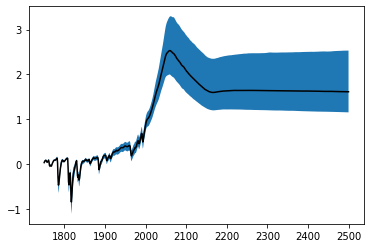

In [42]:
pl.fill_between(np.arange(1750, 1750+nt), np.percentile(result_t[0,...], 5, axis=1), np.percentile(result_t[0,...], 95, axis=1))
pl.plot(np.arange(1750,1750+nt), np.percentile(result_t[0,...], 50, axis=1), color='k');

In [43]:
runs = run_append(
    [
        new_timeseries(
            result_t[:,:,ensemble_member].T,
            n=result_t.shape[1],
            scenario=expt,
            variable=VARIABLES,
            unit=UNITS,
            ensemble_member=ensemble_member,
        )
        for ensemble_member in range(len(config_list))
    ]
)
runs.metadata["source"] = "FaIRv%s AR6 runs %02d.%02d.%d" % (fair.__version__, dt.date.today().day, dt.date.today().month, dt.date.today().year)
runs.to_nc('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_%s.nc' % expt, dimensions=["ensemble_member"])
runs.to_csv('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_%s.csv' % expt)

## ssp585

In [44]:
expt = 'ssp585'
emis_all = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
emis_subset = emis_all[(emis_all['Scenario']==expt)&(emis_all['Region']=='World')]
species=['CO2|MAGICC Fossil and Industrial','CO2|MAGICC AFOLU','CH4','N2O','Sulfur','CO','VOC','NOx','BC','|OC','NH3',
         'CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
         'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
         'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','|CH3Cl']
emis = np.zeros((751,40))
emis[:,0] = np.arange(1750,2501)
for ie, specie in enumerate(species):
    try:
        temp = emis_subset[emis_subset.Variable.str.endswith(specie)].loc[:,'1750':'2500'].values.squeeze()
        emis[:,ie+1] = pd.Series(temp).interpolate().values
    except:
        emis[:,ie+1] = 0
temp = emis_subset[emis_subset['Variable']=='Emissions|NOx|MAGICC Fossil and Industrial|Aircraft'].loc[:,'1750':'2500'].values.squeeze()
aviNOx = pd.Series(temp).interpolate().values
aviNOx_frac = aviNOx/emis[:,8]
# 
unit_convert = np.ones(40)
unit_convert[1]=0.001 * molwt.C/molwt.CO2
unit_convert[2]=0.001 * molwt.C/molwt.CO2
unit_convert[4]=0.001 * molwt.N2/molwt.N2O
unit_convert[5]=molwt.S/molwt.SO2
unit_convert[8]=molwt.N/molwt.NO2

emis = emis * unit_convert

conc_subset = conc_all[(conc_all['Scenario']==expt)&(conc_all['Region']=='World')]
gases=['CO2','CH4','N2O','CF4','C2F6','C6F14','HFC23','HFC32','HFC4310mee','HFC125','HFC134a','HFC143a',
       'HFC227ea','HFC245fa','SF6','CFC11','CFC12','CFC113','CFC114','CFC115','CCl4','CH3CCl3','HCFC22',
       'HCFC141b','HCFC142b','Halon1211','Halon1202','Halon1301','Halon2402','CH3Br','CH3Cl']
conc = np.zeros((751,31))
for ig, gas in enumerate(gases):
    try:
        temp = conc_subset[conc_subset.Variable.str.endswith(gas)].loc[:,'1750':'2500'].values.squeeze()
        conc[:,ig] = pd.Series(temp).interpolate().values
    except:
        conc[:,ig] = 0

nt = 751
def run_fair(args):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        F_solar = np.zeros(751)
        F_volcanic = np.zeros(751)
        F_solar[:351] = args['F_solar']
        F_volcanic[:351] = args['F_volcanic']
        
        C,F,T,ariaci, lambda_eff, ohc, heatflux = fair_scm(
            emissions=emis,
            emissions_driven=False,
            C_pi = conc[0,:],
            C = conc,
            natural=np.zeros((751,2)),
            F_volcanic=F_volcanic,#np.mean(F_volcanic),
            F_solar=F_solar,
            F2x=args['F2x'],
            ariaci_out=True,
            ghg_forcing='Meinshausen',
            scale=np.asarray(args['scale']),
            aerosol_forcing='aerocom+ghan2',
            b_aero = np.asarray(args['b_aero']),
            ghan_params=np.asarray(args['ghan_params']),
            tropO3_forcing='thorhnill+skeie',
            ozone_feedback=args['ozone_feedback'],
            b_tro3 = np.array(args['b_tro3']),
            E_pi=emis[0,:],
            scaleAerosolAR5=False,
            scaleHistoricalAR5=False,
            fixPre1850RCP=False,
            aviNOx_frac=0,
            aCO2land = args['aCO2land'],
            stwv_from_ch4 = args['stwv_from_ch4'],
            F_ref_BC = args['F_ref_BC'],
            E_ref_BC = args['E_ref_BC'],
            efficacy=np.ones(45),
            diagnostics='AR6',
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
        )

        E,Fe,Te,lambda_effe, ohce, heatfluxe, af = inverse_fair_scm(
            conc[:,0],
            F2x=args['F2x'],
            C_pi = conc[0,0],
            r0=args['r0'],
            rt=args['rt'],
            rc=args['rc'],
            F_in = np.sum(F, axis=1),
            temperature_function='Geoffroy',
            lambda_global = args['lambda_global'],  # this and the below only used in two-layer model
            deep_ocean_efficacy = args['deep_ocean_efficacy'],
            ocean_heat_capacity = np.asarray(args['ocean_heat_capacity']),
            ocean_heat_exchange = args['ocean_heat_exchange'],
            )

        nt = len(T)
        cumE = np.cumsum(E) * molwt.CO2/molwt.C*1000.
        Catmpool = C[:,0]*ppm_gtc*molwt.CO2/molwt.C*1000.
        Cburden = (C[:,0]-C[0,0])*ppm_gtc*molwt.CO2/molwt.C*1000.
        ECSeff = args['F2x'] * 0.4778646 / lambda_eff
        af = Cburden/cumE

        return(
            T, T/1.04, np.sum(F, axis=1), F[:,0], F[:,1], F[:,2], np.sum(F[:,:31], axis=1),
            np.sum(F[:,35:41], axis=1), F[:,38], F[:,39], F[:,35], F[:,37],
            ariaci[:,0], ariaci[:,1], heatflux*NTOA_ZJ, heatflux*NTOA_ZJ*0.92,
            af, cumE, T/cumE
        )
    
if __name__ == '__main__':
    with Pool(16) as pool:
        result = list(tqdm(pool.imap(run_fair, config_list), total=len(config_list)))
    result_t = np.array(result).transpose(1,2,0)

  0%|          | 0/2049 [00:00<?, ?it/s]

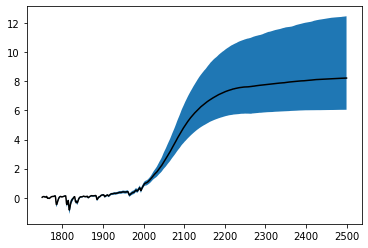

In [45]:
pl.fill_between(np.arange(1750, 1750+nt), np.percentile(result_t[0,...], 5, axis=1), np.percentile(result_t[0,...], 95, axis=1))
pl.plot(np.arange(1750,1750+nt), np.percentile(result_t[0,...], 50, axis=1), color='k');

In [46]:
runs = run_append(
    [
        new_timeseries(
            result_t[:,:,ensemble_member].T,
            n=result_t.shape[1],
            scenario=expt,
            variable=VARIABLES,
            unit=UNITS,
            ensemble_member=ensemble_member,
        )
        for ensemble_member in range(len(config_list))
    ]
)
runs.metadata["source"] = "FaIRv%s AR6 runs %02d.%02d.%d" % (fair.__version__, dt.date.today().day, dt.date.today().month, dt.date.today().year)
runs.to_nc('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_%s.nc' % expt, dimensions=["ensemble_member"])
runs.to_csv('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_%s.csv' % expt)

In [47]:
#from scmdata import 
data = ScmRun.from_nc('../data_output_large/fair-samples/concentration_driven/FaIR1.6.2_ssp126.nc')

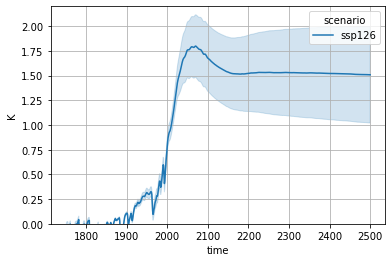

In [48]:
data.filter(variable='Surface Temperature').relative_to_ref_period_mean(year=range(1850,1901)).lineplot()
#pl.xlim(2000, 2100)
pl.ylim(0,2.2)
pl.grid()

In [49]:
data.timeseries().tail()

time                                                                                       1750-01-01 00:00:00  \
climate_model ensemble_member model       region scenario unit variable                                          
FaIRv1.6.2    2044            unspecified World  ssp126   K    Surface Temperature (GMST)             0.033476   
              2045            unspecified World  ssp126   K    Surface Temperature (GMST)             0.034036   
              2046            unspecified World  ssp126   K    Surface Temperature (GMST)             0.028843   
              2047            unspecified World  ssp126   K    Surface Temperature (GMST)             0.030291   
              2048            unspecified World  ssp126   K    Surface Temperature (GMST)             0.035347   

time                                                                                       1751-01-01 00:00:00  \
climate_model ensemble_member model       region scenario unit variable                                          
FaIRv1.6.2    2044            unspecified World  ssp126   K    Surface Temperature (GMST)             0.057625   
              2045            unspecified World  ssp126   K    Surface Temperature (GMST)             0.059890   
              2046            unspecified World  ssp126   K    Surface Temperature (GMST)             0.049767   
              2047            unspecified World  ssp126   K    Surface Temperature (GMST)             0.052992   
              2048            unspecified World  ssp126   K    Surface Temperature (GMST)             0.055336   

time                                                                                       1752-01-01 00:00:00  \
climate_model ensemble_member model       region scenario unit variable                                          
FaIRv1.6.2    2044            unspecified World  ssp126   K    Surface Temperature (GMST)             0.073438   
              2045            unspecified World  ssp126   K    Surface Temperature (GMST)             0.077478   
              2046            unspecified World  ssp126   K    Surface Temperature (GMST)             0.062929   
              2047            unspecified World  ssp126   K    Surface Temperature (GMST)             0.068103   
              2048            unspecified World  ssp126   K    Surface Temperature (GMST)             0.065068   

time                                                                                       1753-01-01 00:00:00  \
climate_model ensemble_member model       region scenario unit variable                                          
FaIRv1.6.2    2044            unspecified World  ssp126   K    Surface Temperature (GMST)             0.082146   
              2045            unspecified World  ssp126   K    Surface Temperature (GMST)             0.086653   
              2046            unspecified World  ssp126   K    Surface Temperature (GMST)             0.068851   
              2047            unspecified World  ssp126   K    Surface Temperature (GMST)             0.076240   
              2048            unspecified World  ssp126   K    Surface Temperature (GMST)             0.067736   

time                                                                                       1754-01-01 00:00:00  \
climate_model ensemble_member model       region scenario unit variable                                          
FaIRv1.6.2    2044            unspecified World  ssp126   K    Surface Temperature (GMST)             0.085278   
              2045            unspecified World  ssp126   K    Surface Temperature (GMST)             0.088043   
              2046            unspecified World  ssp126   K    Surface Temperature (GMST)             0.068679   
              2047            unspecified World  ssp126   K    Surface Temperature (GMST)             0.078624   
              2048            unspecified World  ssp126   K    Surface Temperature (GMST)             0.065716   

time 